In [ ]:
# import pandas as pd
# import os
# import shutil
# from sklearn.model_selection import train_test_split
#
# # Read the CSV file
# csv_file = '../data/comfort-class2.csv'  # Replace with your CSV file path
# df = pd.read_csv(csv_file)
#
# # Split the data into train, val, test (0.8, 0.1, 0.1)
# train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
#
# # Create directories if they don't exist
# os.makedirs('../data/ori_data/train', exist_ok=True)
# os.makedirs('../data/ori_data/val', exist_ok=True)
# os.makedirs('../data/ori_data/test', exist_ok=True)
#
# # Function to move files to the corresponding folder
# def move_files(df, folder_name):
#     for scene in df['Scene']:
#         # Format the scene number to match the file name (e.g., scene-000003.mp4)
#         file_name = f'scene-{scene:06d}.mp4'
#         source_path = os.path.join(os.getcwd(), file_name)
#         dest_path = os.path.join(os.getcwd(), folder_name, file_name)
#
#         # Check if the source file exists
#         if os.path.exists(source_path):
#             # Move the file to the destination folder
#             shutil.move(source_path, dest_path)
#             print(f'Moved {file_name} to {folder_name}')
#         else:
#             print(f'File {file_name} not found in current directory')
#
# # Move files to respective folders
# move_files(train_df, 'train')
# move_files(val_df, 'val')
# move_files(test_df, 'test')
#
# print("File splitting and moving completed.")

In [7]:
import pandas as pd
df = pd.read_csv("../data/comfort-class2.csv")
df['Scene'] = df['Scene'].apply(lambda x: str(f'scene-{int(x):06d}.mp4'))
df.to_csv("../data/comfort-class2.csv", index=False)

In [1]:
import av
import numpy as np
import torch
from transformers import VivitImageProcessor, VivitForVideoClassification
from huggingface_hub import hf_hub_download

def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

def main():
    # Load video
    file_path = hf_hub_download(
        repo_id="nielsr/video-demo",
        filename="eating_spaghetti.mp4",
        repo_type="dataset"
    )
    container = av.open(file_path)

    # Sample frames
    clip_len = 32
    frame_sample_rate = 4
    seg_len = container.streams.video[0].frames
    indices = sample_frame_indices(clip_len, frame_sample_rate, seg_len)
    video = read_video_pyav(container=container, indices=indices)

    # Load model and processor
    image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
    model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400")

    # Modify model for regression (single output)
    model.num_labels = 1
    model.classifier = torch.nn.Linear(model.config.hidden_size, 1)

    # Process video
    inputs = image_processor(list(video), return_tensors="pt")

    # Example target value for regression
    target = torch.tensor([0.75], dtype=torch.float32)  # Replace with actual target

    # Forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, labels=target)
        loss = outputs.loss
        prediction = outputs.logits

    print(f"Loss: {loss.item():.4f}")
    print(f"Predicted value: {prediction.item():.4f}")

if __name__ == "__main__":
    main()

RuntimeError: Failed to import transformers.models.vivit.image_processing_vivit because of the following error (look up to see its traceback):
cannot import name 'float8_e4m3b11fnuz' from 'tensorflow.python.framework.dtypes' (C:\Users\Eric\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\framework\dtypes.py)

In [2]:
from transformers import VivitImageProcessor, VivitForVideoClassification
from huggingface_hub import snapshot_download
import os

# Define local directory to save the model
local_model_dir = "./vivit-b-16x2-kinetics400"

# Create directory if it doesn't exist
os.makedirs(local_model_dir, exist_ok=True)

# Download the model weights and configuration from Hugging Face Hub
snapshot_download(repo_id="google/vivit-b-16x2-kinetics400", local_dir=local_model_dir)

# Load the image processor and model from the local directory
image_processor = VivitImageProcessor.from_pretrained(local_model_dir)
model = VivitForVideoClassification.from_pretrained(local_model_dir)

print(f"Model and processor successfully downloaded and loaded from {local_model_dir}")

RuntimeError: Failed to import transformers.models.vivit.image_processing_vivit because of the following error (look up to see its traceback):
cannot import name 'float8_e4m3b11fnuz' from 'tensorflow.python.framework.dtypes' (C:\Users\Eric\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\framework\dtypes.py)

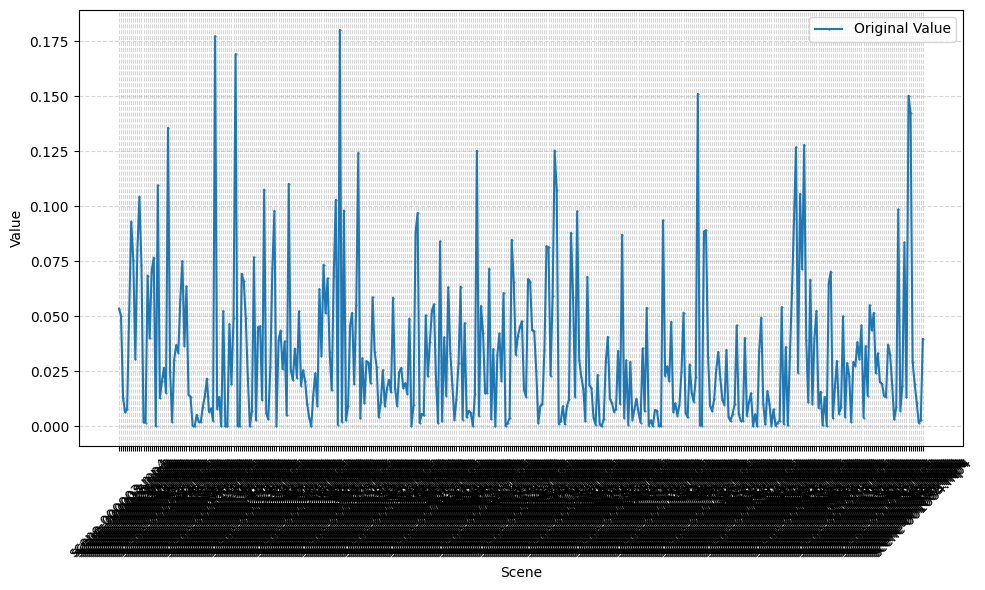

In [12]:
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("../data/comfort-class2.csv")
# 计算标准化后的值
df['Value_std'] = StandardScaler().fit_transform(df[['Value']])

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(df['Scene'], df['Value'], marker='o', label='Original Value', markersize=0.5)
# plt.plot(df['Scene'], df['Value_std'], marker='s', linestyle='--', label='Standardized Value', markersize=0.5)
plt.xticks(rotation=45)  # 旋转x轴标签避免重叠
plt.xlabel('Scene')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()  # 调整布局
plt.show()

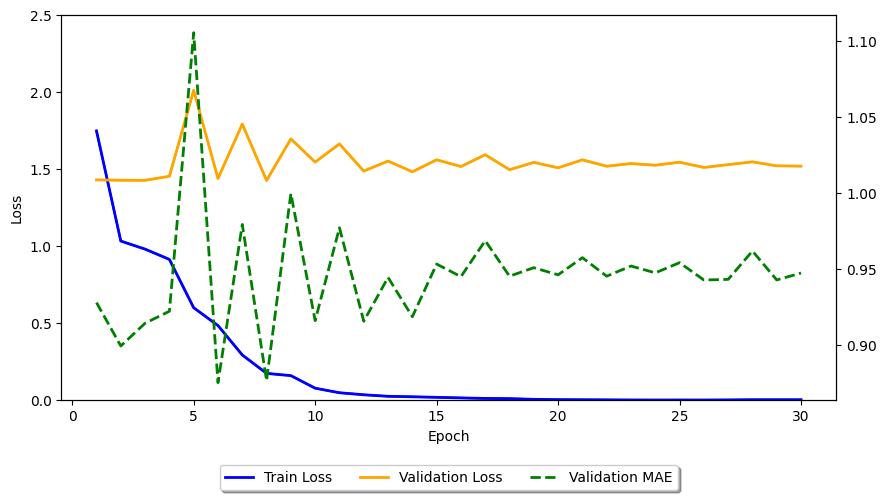

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

data = """
epoch,train_loss,val_loss,val_mae,test_loss,test_mae
1,1.7485,1.4305,0.9278,,
2,1.0335,1.4282,0.8992,,
3,0.9809,1.4277,0.9142,,
4,0.9142,1.4541,0.9221,,
5,0.6003,2.0122,1.1057,,
6,0.4848,1.4395,0.8750,,
7,0.2938,1.7929,0.9793,,
8,0.1740,1.4267,0.8764,,
9,0.1596,1.6968,0.9997,,
10,0.0779,1.5462,0.9159,,
11,0.0483,1.6642,0.9771,,
12,0.0352,1.4879,0.9155,,
13,0.0253,1.5527,0.9444,,
14,0.0221,1.4833,0.9185,,
15,0.0187,1.5610,0.9532,,
16,0.0148,1.5173,0.9449,,
17,0.0114,1.5940,0.9686,,
18,0.0102,1.4967,0.9452,,
19,0.0056,1.5442,0.9508,,
20,0.0036,1.5090,0.9461,,
21,0.0028,1.5607,0.9574,,
22,0.0022,1.5192,0.9452,,
23,0.0014,1.5366,0.9519,,
24,0.0012,1.5257,0.9474,,
25,0.0013,1.5454,0.9541,,
26,0.0012,1.5113,0.9427,,
27,0.0018,1.5297,0.9431,,
28,0.0030,1.5477,0.9618,,
29,0.0029,1.5217,0.9427,,
30,0.0029,1.5199,0.9473,,
"""

df = pd.read_csv(StringIO(data))

plt.figure(figsize=(10, 5))

# 主坐标轴（左侧）
plt.plot(df['epoch'], df['train_loss'], 'b-', label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], 'orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 2.5)  # 根据数据范围设定


# 合并图例
line1, = plt.plot(df['epoch'], df['train_loss'], 'b-', linewidth=2, label='Train Loss')
line2, = plt.plot(df['epoch'], df['val_loss'], 'orange', linewidth=2, label='Validation Loss')

# 绘制次坐标轴曲线（右侧）
plt.twinx()
line3, = plt.plot(df['epoch'], df['val_mae'], 'g--', linewidth=2, label='Validation MAE')

# 合并图例的三种方法（任选其一）：

# 方法1：自动合并（推荐）
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=3,
           frameon=True,
           shadow=True)

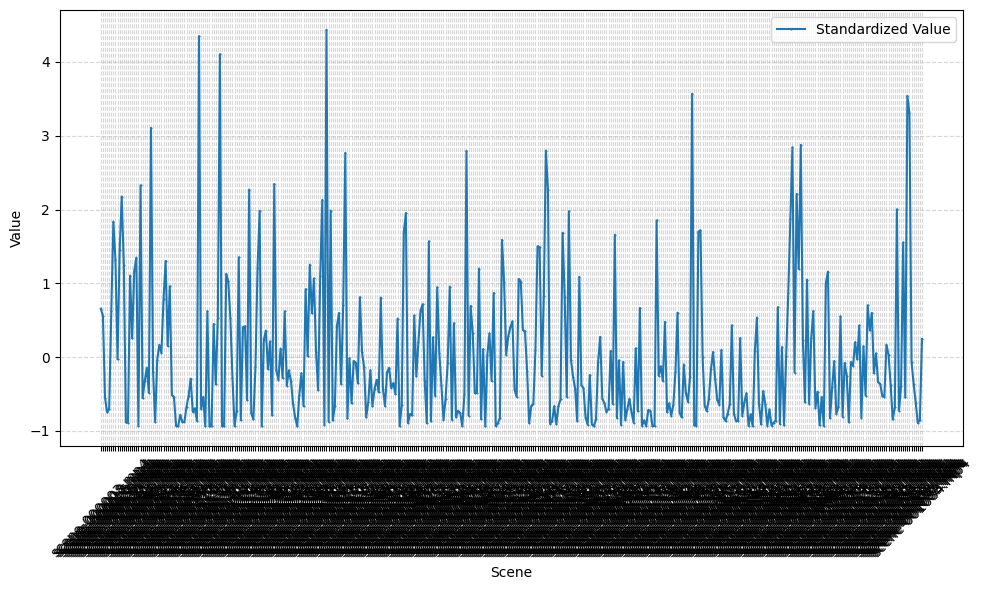

In [4]:
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("../data/comfort-class2.csv")
# 计算标准化后的值
df['Value_std'] = StandardScaler().fit_transform(df[['Value']])
plt.figure(figsize=(10, 6))
# plt.plot(df['Scene'], df['Value'], marker='o', label='Original Value', markersize=0.5)
plt.plot(df['Scene'], df['Value_std'], marker='s', linestyle='-', label='Standardized Value', markersize=0.5)
plt.xticks(rotation=45)  # 旋转x轴标签避免重叠
plt.xlabel('Scene')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()  # 调整布局
plt.show()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
def show(name):
    name = "../" + name + "/training_log.csv"
    df = pd.read_csv(name)

    plt.figure(figsize=(10, 5))

    # 主坐标轴（左侧）
    plt.plot(df['epoch'], df['train_loss'], 'b-', label='Train Loss')
    plt.plot(df['epoch'], df['val_loss'], 'orange', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    minvalue = min(df['val_loss'].min(), df['train_loss'].min())
    maxvalue = max(df['val_loss'].max(), df['train_loss'].max())
    plt.ylim(minvalue - 0.1, maxvalue + 0.1)  # 根据数据范围设定


    # 合并图例
    line1, = plt.plot(df['epoch'], df['train_loss'], 'b-', linewidth=2, label='Train Loss')
    line2, = plt.plot(df['epoch'], df['val_loss'], 'orange', linewidth=2, label='Validation Loss')

    # 绘制次坐标轴曲线（右侧）
    plt.twinx()
    line3, = plt.plot(df['epoch'], df['val_mae'], 'g--', linewidth=2, label='Validation MAE')

    # 合并图例的三种方法（任选其一）：

    # 方法1：自动合并（推荐）
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.15),
               ncol=3,
               frameon=True,
               shadow=True)

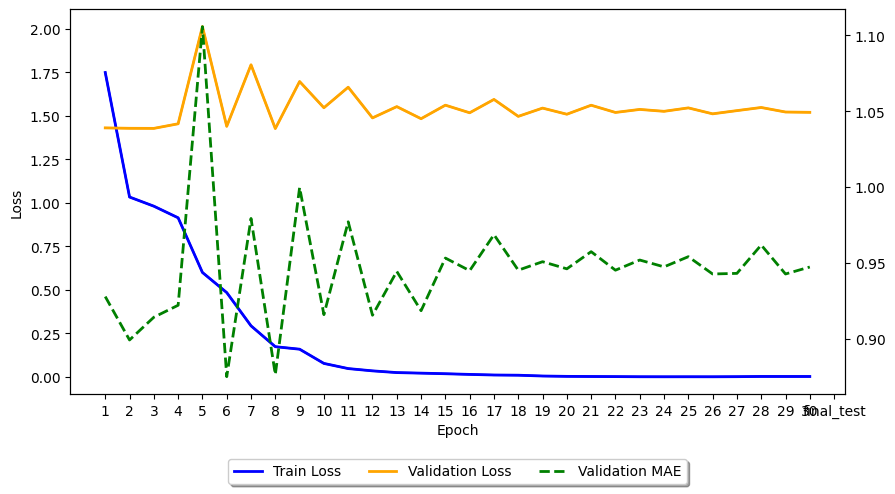

In [3]:
show("bigger_batch")

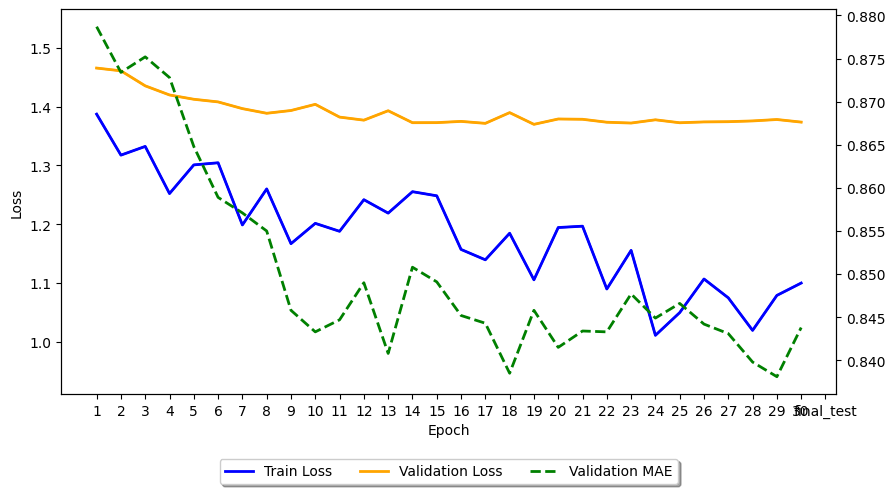

In [4]:
show("unfreeze")

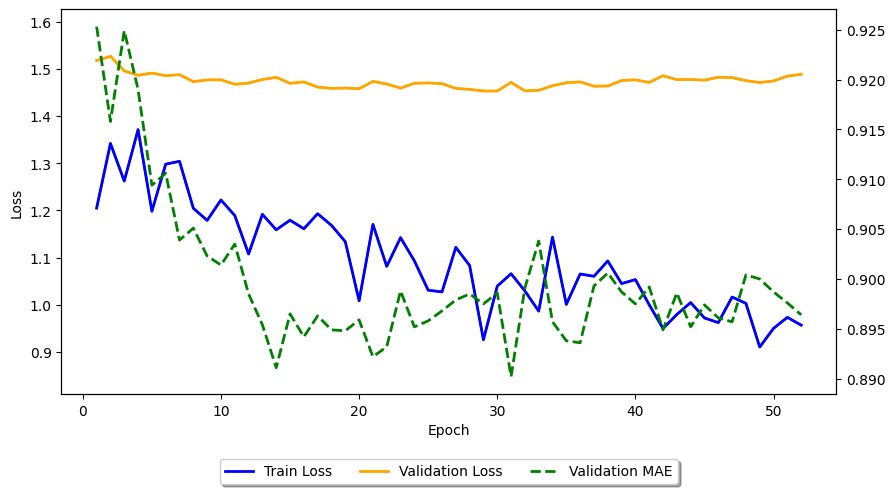

In [5]:
show("unfreeze_180")

C:\Users\Eric\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eric\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eric\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eric\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eric\AppData\Local\Programs\Python\Pyth

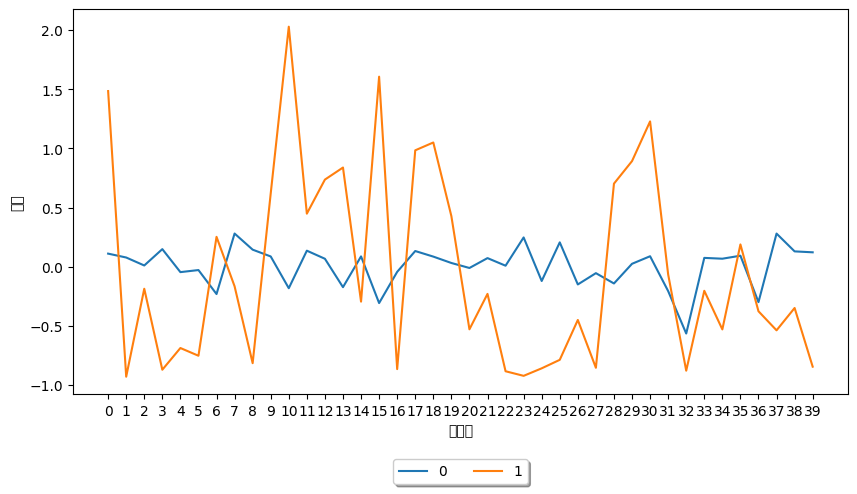

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv("../unfreeze/results.csv")
df = df.T
# 设置图形大小
plt.figure(figsize=(10, 5))

# 绘制每一列的折线图，使用行索引作为横坐标
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# 设置x轴和y轴标签
plt.xlabel('行索引')
plt.ylabel('列值')

# 添加图例
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=True,
    shadow=True
)

# 显示图形
plt.show()
